# INFO 2950 - Phase II

## Research Question
Is there a relationship between food availability, both grocery stores and restaurants, and county demographics across the United States? Are there specific kinds of grocery stores and restaurants depending on the demographics in the county? Is there a relationship between grocery stores and fast food restaurants within each county? 

## Data Descriptions

We are looking the Food Environment Atlas from the USDA. This data set, organized into multiple tabs of an Excel file, splits data into counties of the United States. It has a tab for data on each county's population, income and access to stores, grocery stores, restaurants, assisstance (such as SNAP and WIC), food insecurity, taxes, local food outlets, health, and socioeconomic demographics. We are choosing to look at the data sets about grocery stores, restaurants, and socioeconomic demographics.

The grocery store data contains the amounts of each type of grocery store and how many of ech type per 1,000 people for 2011 and 2016. The restaurant data contains the amounts of each type of restaurant and how many of each type per 1,000 people for 2011 and 2016. The socioeconomic demographic data has the racial and age makeup by percent from 2010, the poverty rate from 2015, and other income data from 2010. 

Link to data set: https://www.ers.usda.gov/data-products/food-environment-atlas/data-access-and-documentation-downloads/#Current%20Version

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb
from sklearn.linear_model import LinearRegression, LogisticRegression

## Data Cleaning

The original data was contained in an excel file, with each subjet on a different tab. The first step was to download each tab we were working with as a csv. We started with the grocery stores data.

In [86]:
stores = pd.read_csv('Store_Access.csv')
stores.head()

,FIPS,State,County,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,GROCPTH16,PCH_GROCPTH_11_16,SUPERC11,...,PCH_SNAPS_12_17,SNAPSPTH12,SNAPSPTH17,PCH_SNAPSPTH_12_17,WICS11,WICS16,PCH_WICS_11_16,WICSPTH11,WICSPTH16,PCH_WICSPTH_11_16
0,1001,AL,Autauga,5,3,-40.000000,0.090581,0.054271,-40.085748,1,...,19.376392,0.674004,0.804747,19.397900,5.0,5.0,0.000000,0.090567,0.090511,-0.061543
1,1003,AL,Baldwin,27,29,7.407407,0.144746,0.139753,-3.449328,6,...,36.927711,0.725055,0.890836,22.864524,26.0,28.0,7.692307,0.139380,0.134802,-3.284727
2,1005,AL,Barbour,6,4,-33.333333,0.219370,0.155195,-29.254287,0,...,3.349282,1.280590,1.424614,11.246689,7.0,6.0,-14.285714,0.255942,0.232387,-9.203081
3,1007,AL,Bibb,6,5,-16.666667,0.263794,0.220916,-16.254289,1,...,11.794872,0.719122,0.801423,11.444711,6.0,5.0,-16.666666,0.263771,0.221474,-16.035471
4,1009,AL,Blount,7,5,-28.571429,0.121608,0.086863,-28.571429,1,...,5.701754,0.657144,0.692374,5.361034,8.0,8.0,0.000000,0.139000,0.139089,0.064332


Next, we determined which columns we would potentially want to use based on our reseach questions, and dropped the rest from our data frame.

In [87]:
stores = stores.drop(['PCH_GROCPTH_11_16','PCH_SUPERCPTH_11_16', 'PCH_CONVSPTH_11_16', \
                      'PCH_SPECSPTH_11_16','SNAPS12', 'SNAPS17', 'PCH_SNAPS_12_17', 'SNAPSPTH12', \
                      'SNAPSPTH17', 'PCH_SNAPSPTH_12_17', 'WICS11', 'WICS16', 'PCH_WICS_11_16', 'WICSPTH11', \
                      'WICSPTH16', 'PCH_WICSPTH_11_16','FIPS', 'PCH_SUPERC_11_16', 'PCH_GROC_11_16',\
                      'PCH_CONVS_11_16', 'PCH_SPECS_11_16'] ,axis=1)
stores.head()

,State,County,GROC11,GROC16,GROCPTH11,GROCPTH16,SUPERC11,SUPERC16,SUPERCPTH11,SUPERCPTH16,CONVS11,CONVS16,CONVSPTH11,CONVSPTH16,SPECS11,SPECS16,SPECSPTH11,SPECSPTH16
0,AL,Autauga,5,3,0.090581,0.054271,1,1,0.018116,0.018090,31,31,0.561604,0.560802,1,1,0.018116,0.018090
1,AL,Baldwin,27,29,0.144746,0.139753,6,7,0.032166,0.033733,107,118,0.573622,0.568650,20,27,0.107219,0.130115
2,AL,Barbour,6,4,0.219370,0.155195,0,1,0.000000,0.038799,22,19,0.804358,0.737177,3,2,0.109685,0.077598
3,AL,Bibb,6,5,0.263794,0.220916,1,1,0.043966,0.044183,19,15,0.835348,0.662749,0,0,0.000000,0.000000
4,AL,Blount,7,5,0.121608,0.086863,1,1,0.017373,0.017373,30,27,0.521177,0.469059,1,0,0.017373,0.000000


The data from the USDA had a tab in the Excel file that explained what each variable meant, and then used the variable names as the titles for the columns in the rest of the tabs. For our purposes, we wanted to convert the variable names back to their real names so we could see their meaning easily by looking at our data frame. To do so, we referred to the variable tab and manually renamed each column to easily understand its meaning.

In [88]:
stores = stores.rename(columns={'GROC11':'Grocery_2011', 'GROC16': 'Grocery_2016', \
                                'GROCPTH11':'Grocery_per_1000_2011', \
                                'GROCPTH16':'Grocery_per_1000_2016', 'SUPERC11': 'Supercenter_2011', \
                                'SUPERC16': 'Supercenter_2016', \
                                'SUPERCPTH11':'Supercenter_per_1000_2011','SUPERCPTH16':'Supercenter_per_1000_2016', \
                                'CONVS11':'Convenience_2011', 'CONVS16':'Convenience_2016', \
                                'CONVSPTH11':'Convenience_per_1000_2011','CONVSPTH16':'Convenience_per_1000_2016', \
                                'SPECS11':'Specialized_2011', 'SPECS16':'Specialized_2016', \
                                'SPECSPTH11':'Specialized_per_1000_2011', 'SPECSPTH16':'Specialized_per_1000_2016'})
stores.head()                                
                                

,State,County,Grocery_2011,Grocery_2016,Grocery_per_1000_2011,Grocery_per_1000_2016,Supercenter_2011,Supercenter_2016,Supercenter_per_1000_2011,Supercenter_per_1000_2016,Convenience_2011,Convenience_2016,Convenience_per_1000_2011,Convenience_per_1000_2016,Specialized_2011,Specialized_2016,Specialized_per_1000_2011,Specialized_per_1000_2016
0,AL,Autauga,5,3,0.090581,0.054271,1,1,0.018116,0.018090,31,31,0.561604,0.560802,1,1,0.018116,0.018090
1,AL,Baldwin,27,29,0.144746,0.139753,6,7,0.032166,0.033733,107,118,0.573622,0.568650,20,27,0.107219,0.130115
2,AL,Barbour,6,4,0.219370,0.155195,0,1,0.000000,0.038799,22,19,0.804358,0.737177,3,2,0.109685,0.077598
3,AL,Bibb,6,5,0.263794,0.220916,1,1,0.043966,0.044183,19,15,0.835348,0.662749,0,0,0.000000,0.000000
4,AL,Blount,7,5,0.121608,0.086863,1,1,0.017373,0.017373,30,27,0.521177,0.469059,1,0,0.017373,0.000000


Next, we converted the demographics tab of the Excel sheet into a csv and performed the same procedure on the demographics data frame, first dropping the columns that were unnecessary in relation to our research questions, and the convert the column names back to their titles based on the variable codes.

In [114]:
demographics = pd.read_csv('county_demographics.csv')
demographics.head()

,FIPS,State,County,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,MEDHHINC15,POVRATE15,PERPOV10,CHILDPOVRATE15,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,22.987408,52387.0,12.9,0,19.6,0,1,0.0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,21.906982,31433.0,32.0,1,45.2,1,0,0.0
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,22.696923,40767.0,22.2,0,29.3,1,1,0.0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,24.608353,50487.0,14.7,0,22.2,0,1,0.0


In [115]:
demographics = demographics.drop(['PCT_65OLDER10', 'PCT_18YOUNGER10', 'PERPOV10', 'PERCHLDPOV10', \
                                 'POPLOSS10', 'FIPS'], axis=1)
demographics.head()

,State,County,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,MEDHHINC15,POVRATE15,CHILDPOVRATE15,METRO13
0,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,56580.0,12.7,18.8,1
1,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,52387.0,12.9,19.6,1
2,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,31433.0,32.0,45.2,0
3,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,40767.0,22.2,29.3,1
4,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,50487.0,14.7,22.2,1


In [116]:
demographics = demographics.rename(columns={'PCT_NHWHITE10':'Percent_White_2010', 'PCT_NHBLACK10':'Percent_Black_2010',\
                                           'PCT_HISP10':'Percent_Hispanic_2010', 'PCT_NHASIAN10':'Percent_Asian_2010',\
                                           'PCT_NHNA10':'Percent_Native_American_2010', 'PCT_NHPI10':'Percent_Hawaiian_2010',\
                                           'MEDHHINC15':'Median_household_income_2015', 'POVRATE15':'Poverty_Rate_2015',\
                                           'CHILDPOVRATE15':'Child_poverty_rate_2015', 'METRO13':'Metro'})
demographics.head()

,State,County,Percent_White_2010,Percent_Black_2010,Percent_Hispanic_2010,Percent_Asian_2010,Percent_Native_American_2010,Percent_Hawaiian_2010,Median_household_income_2015,Poverty_Rate_2015,Child_poverty_rate_2015,Metro
0,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,56580.0,12.7,18.8,1
1,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,52387.0,12.9,19.6,1
2,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,31433.0,32.0,45.2,0
3,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,40767.0,22.2,29.3,1
4,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,50487.0,14.7,22.2,1


Then, we converted the restaurants tab of the Excel sheet into a csv file, created another data frame, dropped the columns we were not interested in, and changed the column names from the variable codes. 

In [92]:
restaurants = pd.read_csv('Restaurants.csv')
restaurants.head()

,FIPS,State,County,FFR11,FFR16,PCH_FFR_11_16,FFRPTH11,FFRPTH16,PCH_FFRPTH_11_16,FSR11,FSR16,PCH_FSR_11_16,FSRPTH11,FSRPTH16,PCH_FSRPTH_11_16,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12
0,1001,AL,Autauga,34,44,29.411765,0.615953,0.795977,29.226817,32,31,-3.125000,0.579721,0.560802,-3.263448,649.511367,674.80272,484.381507,512.280987
1,1003,AL,Baldwin,121,156,28.925620,0.648675,0.751775,15.893824,216,236,9.259259,1.157966,1.137300,-1.784662,649.511367,674.80272,484.381507,512.280987
2,1005,AL,Barbour,19,23,21.052632,0.694673,0.892372,28.459320,17,14,-17.647059,0.621549,0.543183,-12.608237,649.511367,674.80272,484.381507,512.280987
3,1007,AL,Bibb,6,7,16.666667,0.263794,0.309283,17.243995,5,7,40.000000,0.219829,0.309283,40.692794,649.511367,674.80272,484.381507,512.280987
4,1009,AL,Blount,20,23,15.000000,0.347451,0.399569,15.000000,15,12,-20.000000,0.260589,0.208471,-20.000000,649.511367,674.80272,484.381507,512.280987


In [93]:
restaurants = restaurants.drop(['PCH_FFRPTH_11_16', 'PCH_FSRPTH_11_16', 'PC_FFRSALES07', 'PC_FSRSALES07',\
                               'FIPS', 'PCH_FFR_11_16', 'PCH_FSR_11_16'], axis=1)
restaurants.head()

,State,County,FFR11,FFR16,FFRPTH11,FFRPTH16,FSR11,FSR16,FSRPTH11,FSRPTH16,PC_FFRSALES12,PC_FSRSALES12
0,AL,Autauga,34,44,0.615953,0.795977,32,31,0.579721,0.560802,674.80272,512.280987
1,AL,Baldwin,121,156,0.648675,0.751775,216,236,1.157966,1.137300,674.80272,512.280987
2,AL,Barbour,19,23,0.694673,0.892372,17,14,0.621549,0.543183,674.80272,512.280987
3,AL,Bibb,6,7,0.263794,0.309283,5,7,0.219829,0.309283,674.80272,512.280987
4,AL,Blount,20,23,0.347451,0.399569,15,12,0.260589,0.208471,674.80272,512.280987


In [94]:
restaurants = restaurants.rename(columns={'FFR11':'Fast_food_2011', 'FFR16':'Fast_food_2016', \
                                          'FFRPTH11':'Fast_food_per_1000_2011',\
                                          'FFRPTH16':'Fast_food_per_1000_2016', 'FSR11':'Full_service_2011',\
                                          'FSR16':'Full_service_2016',\
                                          'FSRPTH11':'Full_service_per_1000_2011', \
                                          'FSRPTH16':'Full_service_per_1000_2016',\
                                          'PC_FFRSALES12':'Fast_food_expenditures_per_capita_2012', \
                                          'PC_FSRSALES12':'Full_service_expenditures_per_capita_2012'})
restaurants.head()

,State,County,Fast_food_2011,Fast_food_2016,Fast_food_per_1000_2011,Fast_food_per_1000_2016,Full_service_2011,Full_service_2016,Full_service_per_1000_2011,Full_service_per_1000_2016,Fast_food_expenditures_per_capita_2012,Full_service_expenditures_per_capita_2012
0,AL,Autauga,34,44,0.615953,0.795977,32,31,0.579721,0.560802,674.80272,512.280987
1,AL,Baldwin,121,156,0.648675,0.751775,216,236,1.157966,1.137300,674.80272,512.280987
2,AL,Barbour,19,23,0.694673,0.892372,17,14,0.621549,0.543183,674.80272,512.280987
3,AL,Bibb,6,7,0.263794,0.309283,5,7,0.219829,0.309283,674.80272,512.280987
4,AL,Blount,20,23,0.347451,0.399569,15,12,0.260589,0.208471,674.80272,512.280987


Now we have all three of the data frames we want to use formatted so that we can use them for our exploration. Next, we want to check for missing values in our dataframes. 

In [117]:
print(stores.columns[stores.isnull().any()])
print(demographics.columns[demographics.isnull().any()])
print(restaurants.columns[restaurants.isnull().any()])

Index([], dtype='object')
Index(['Median_household_income_2015', 'Poverty_Rate_2015',
       'Child_poverty_rate_2015'],
      dtype='object')
Index([], dtype='object')


We need to input NaN for missing data

In [118]:
stores.fillna(np.nan, inplace=True)
demographics.fillna(np.nan, inplace=True)
restaurants.fillna(np.nan, inplace=True)

In [119]:
demographics[demographics.isnull().any(axis=1)]

,State,County,Percent_White_2010,Percent_Black_2010,Percent_Hispanic_2010,Percent_Asian_2010,Percent_Native_American_2010,Percent_Hawaiian_2010,Median_household_income_2015,Poverty_Rate_2015,Child_poverty_rate_2015,Metro
92,AK,Wade Hampton,2.667918,0.013407,0.093846,0.227913,94.945703,0.000000,NaN,NaN,NaN,0
548,HI,Kalawao,26.666667,0.000000,1.111111,7.777778,0.000000,48.888889,NaN,NaN,NaN,1
2417,SD,Shannon,2.804357,0.029442,2.193434,0.103047,94.096864,0.014721,NaN,NaN,NaN,0
2916,VA,Bedford,75.072324,20.009643,2.153648,0.658952,0.112504,0.016072,NaN,NaN,NaN,1


## Exploration

In [103]:
grocery_to_fastfood = duckdb.sql('SELECT stores.State, stores.County, stores.Grocery_2011, restaurants.Fast_food_2011 \
FROM stores INNER JOIN restaurants ON stores.county=restaurants.county').df()
grocery_to_fastfood.head()

,State,County,Grocery_2011,Fast_food_2011
0,AL,Autauga,5,34
1,AL,Baldwin,27,28
2,AL,Barbour,6,7
3,AL,Bibb,6,182
4,AL,Blount,7,63


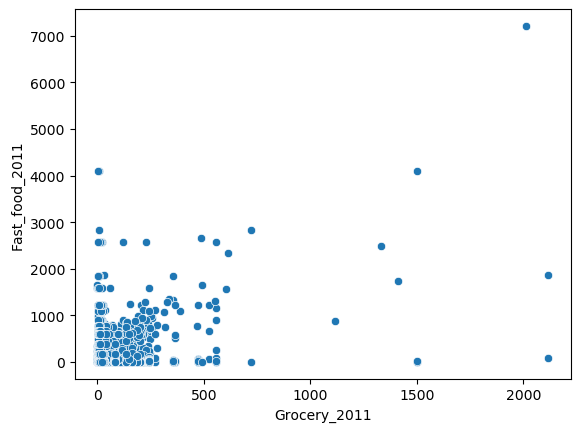

In [108]:
sns.scatterplot(data = grocery_to_fastfood, x = 'Grocery_2011', y= 'Fast_food_2011')
plt.show()

In [122]:
new = duckdb.sql('SELECT grocery_to_fastfood.State, grocery_to_fastfood.County, grocery_to_fastfood.Grocery_2011,\
grocery_to_fastfood.Fast_food_2011, demographics.Percent_White_2010, demographics.Percent_Black_2010, \
demographics.Percent_Asian_2010, demographics.Percent_Hispanic_2010, demographics.Percent_Native_American_2010, \
demographics.Percent_Hawaiian_2010 FROM grocery_to_fastfood INNER JOIN demographics ON \
grocery_to_fastfood.County=demographics.County').df()

In [123]:
new.head()

,State,County,Grocery_2011,Fast_food_2011,Percent_White_2010,Percent_Black_2010,Percent_Asian_2010,Percent_Hispanic_2010,Percent_Native_American_2010,Percent_Hawaiian_2010
0,AL,Autauga,5,34,77.246156,17.582599,0.855766,2.400542,0.397647,0.040314
1,AL,Baldwin,27,28,54.033246,41.264217,1.268591,2.010061,0.185914,0.039370
2,AL,Barbour,6,7,96.479595,0.723371,0.204955,0.578697,0.548556,0.018084
3,AL,Bibb,6,182,42.105602,51.909712,1.602088,2.821655,0.184510,0.047574
4,AL,Blount,7,63,92.057556,2.694090,0.701569,2.797334,0.296724,0.020324


In [196]:
majority_white = duckdb.sql('SELECT State, County, Grocery_2011, Fast_food_2011 FROM new WHERE Percent_White_2010>50').df()
majority_black = duckdb.sql('SELECT State, County, Grocery_2011, Fast_food_2011 FROM new WHERE Percent_Black_2010>50').df()
majority_asian = duckdb.sql('SELECT State, County, Grocery_2011, Fast_food_2011 FROM new WHERE Percent_Asian_2010>50').df()
majority_hispanic = duckdb.sql('SELECT State, County, Grocery_2011, Fast_food_2011 FROM new WHERE Percent_Hispanic_2010>50').df()
majority_NA = duckdb.sql('SELECT State, County, Grocery_2011, Fast_food_2011 FROM new WHERE Percent_Native_American_2010>50').df()
majority_hawaiian = duckdb.sql('SELECT State, County, Grocery_2011, Fast_food_2011 FROM new WHERE Percent_Hawaiian_2010>50').df()

majorities = [majority_white, majority_black, majority_asian, majority_hispanic, majority_NA, majority_hawaiian]
count = []
mean_groc = []
mean_ff = []
for x in majorities:
    count.append(x.shape[0])
    mean_groc.append(x['Grocery_2011'].mean())
    mean_ff.append(x['Fast_food_2011'].mean())
print(count)
print(mean)

data = {'Majority' : ['White', 'Black', 'Asian', 'Hispanic', 'Native_American', 'Hawaiian'], 'Number_of_counties' : \
       count, 'Average_grocery_stores_2011' : mean_groc, 'Average_fast_food_2011': mean_ff}
majority_df = pd.DataFrame(data)
majority_df.head(6)

[182293, 8349, 0, 1019, 644, 0]
[14.861569012523795, 16.613726194753863, nan, 21.78999018645731, 10.487577639751553, nan]


,Majority,Number_of_counties,Average_grocery_stores_2011,Average_fast_food_2011
0,White,182293,14.861569,56.836944
1,Black,8349,16.613726,66.867888
2,Asian,0,NaN,NaN
3,Hispanic,1019,21.789990,65.233562
4,Native_American,644,10.487578,43.468944
5,Hawaiian,0,NaN,NaN


In [213]:
nys_stores = duckdb.sql("SELECT * FROM stores WHERE State = 'NY'").df()
nys_df = duckdb.sql("SELECT * FROM nys_stores INNER JOIN restaurants ON nys_stores.County = restaurants.County").df()
nys_df = duckdb.sql("SELECT * FROM nys_df INNER JOIN demographics ON nys_df.County = demographics.County").df()
nys_df.head()

,State,County,Grocery_2011,Grocery_2016,Grocery_per_1000_2011,Grocery_per_1000_2016,Supercenter_2011,Supercenter_2016,Supercenter_per_1000_2011,Supercenter_per_1000_2016,...,Percent_White_2010,Percent_Black_2010,Percent_Hispanic_2010,Percent_Asian_2010,Percent_Native_American_2010,Percent_Hawaiian_2010,Median_household_income_2015,Poverty_Rate_2015,Child_poverty_rate_2015,Metro
0,NY,Franklin,12,13,0.232766,0.254209,1,1,0.019397,0.019554,...,79.639793,3.819707,14.856170,0.160863,0.381655,0.006308,38535.0,21.1,32.4,0
1,NY,Greene,14,13,0.286551,0.273592,1,1,0.020468,0.021046,...,17.269210,81.249309,0.762852,0.165837,0.121614,0.000000,25398.0,37.7,54.7,0
2,NY,Jefferson,25,34,0.212213,0.298026,2,3,0.016977,0.026296,...,51.667512,41.841340,3.870815,1.379722,0.217323,0.023388,48415.0,18.0,26.2,1
3,NY,Madison,14,11,0.192070,0.154085,1,1,0.013719,0.014008,...,66.140300,23.749817,4.600805,2.439287,0.697408,0.095875,59117.0,13.3,19.1,1
4,NY,Monroe,185,190,0.247505,0.254240,9,11,0.012041,0.014719,...,54.712155,41.533726,0.953702,0.290446,1.109762,0.017340,35163.0,28.6,35.7,0


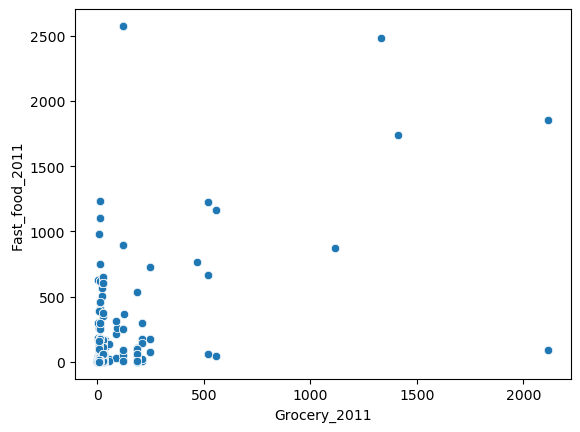

In [214]:
sns.scatterplot(data = nys_df, x = 'Grocery_2011', y= 'Fast_food_2011')
plt.show()

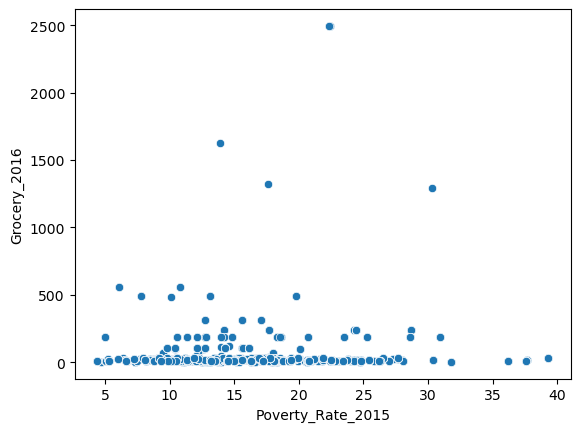

In [219]:
sns.scatterplot(data = nys_df, x='Poverty_Rate_2015', y = 'Grocery_2016')
plt.show()

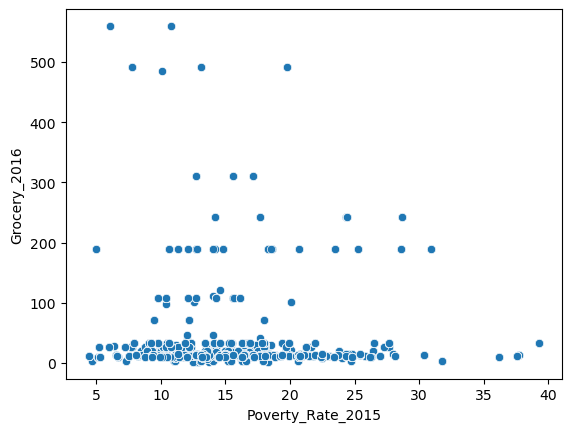

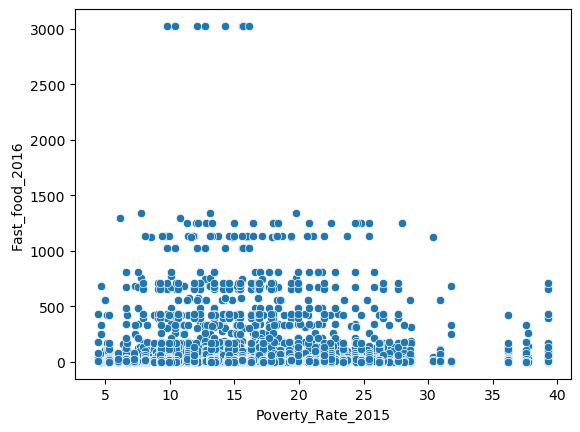

In [222]:
nys_no_outliers = duckdb.sql('SELECT * FROM nys_df WHERE Grocery_2016<1000').df()
sns.scatterplot(data = nys_no_outliers, x='Poverty_Rate_2015', y = 'Grocery_2016')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Poverty_Rate_2015', y = 'Fast_food_2016')
plt.show()

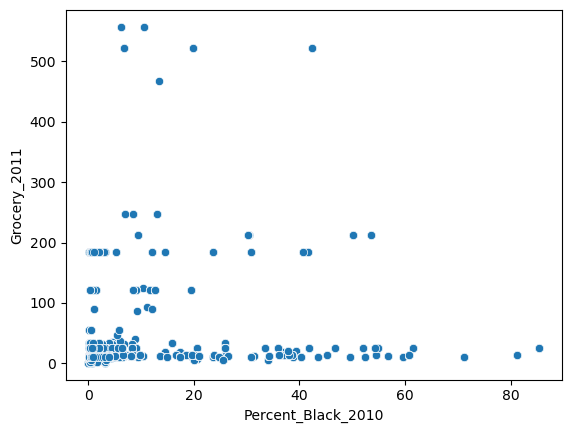

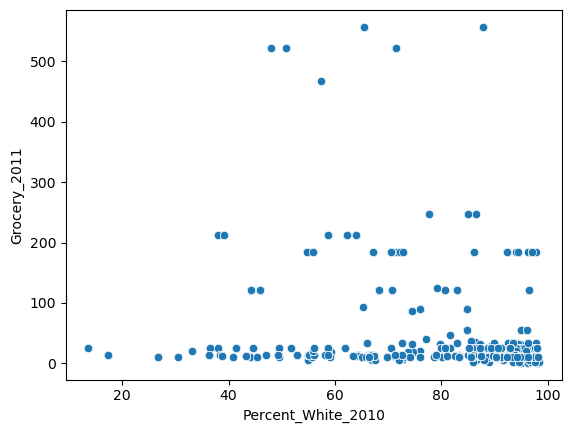

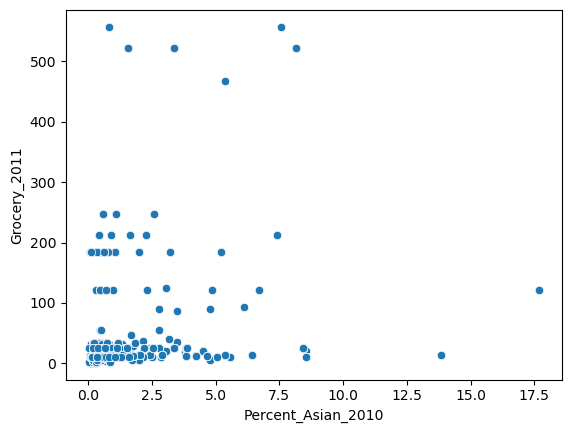

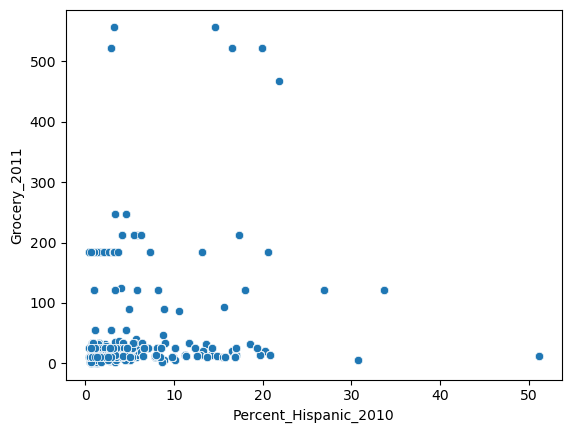

In [226]:
sns.scatterplot(data = nys_no_outliers, x='Percent_Black_2010', y = 'Grocery_2011')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_White_2010', y = 'Grocery_2011')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Asian_2010', y = 'Grocery_2011')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Hispanic_2010', y = 'Grocery_2011')
plt.show()